In [1]:
# General libs for file paths, data extraction, etc
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile # To extract zipfiles
import urllib3 
urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import nctoolkit as nc
import pandas as pd
from dask import delayed
from scipy.interpolate import griddata


# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib import cm
# If any of these are missing, just pip install them to your conda environment, or run a cell with something like this: 
# !pip install cdsapi
# !pip install urllib3 

nctoolkit is using Climate Data Operators version 2.4.0


In [2]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '24cacaba-7f25-4efe-9b98-40828f792491'
DATADIR = '/n/holystore01/LABS/mccoll_lab/Lab/amatthews/Data/Data_Jan24/'
filename='ERA5_RCE_temp'

In [ ]:
dataset = "reanalysis-era5-pressure-levels-monthly-means"
c = cdsapi.Client(url=URL, key=KEY)

request = {
    'product_type': ['monthly_averaged_reanalysis'],
    'variable': [
        'temperature',
        'geopotential'
    ],
    "pressure_level": [
        "1", "2", "3",
        "5", "7", "10",
        "20", "30", "50",
        "70", "100", "125",
        "150", "175", "200",
        "225", "250", "300",
        "350", "400", "450",
        "500", "550", "600",
        "650", "700", "750",
        "775", "800", "825",
        "850", "875", "900",
        "925", "950", "975",
        "1000"
    ],
    'year': ['2000'],
    'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
    'time': ['00:00'],
    'data_format': 'netcdf',
    'download_format': 'zip'
}

c.retrieve(dataset, request, 
          f'{DATADIR}{filename}.zip')

print(f'{DATADIR}{filename}.zip')

with zipfile.ZipFile(f'{DATADIR}{filename}.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{DATADIR}')

In [3]:
datafile_name = 'data_0.nc'
df = xr.open_dataset(f'{DATADIR}{datafile_name}')

In [4]:
df['valid_time'] = pd.to_datetime(df.valid_time).strftime('%Y%m%d').astype(int)
df = df.rename({'valid_time':'date'})
# df = xr.merge((df,df2))

In [5]:
N = len(df.pressure_level)

In [6]:
lapse_rate = np.zeros(N)

In [7]:
numerator = df.t.shift(pressure_level=-1) - df.t.shift(pressure_level=1)
denominator = df.z.shift(pressure_level=-1) - df.z.shift(pressure_level=1)

# Compute the lapse rate
lapse_rate = numerator / denominator

# # Add NaN to the edges to maintain the same dimension size
# lapse_rate = lapse_rate.where(df.pressure_level != df.pressure_level[0], other=float('nan'))
# lapse_rate = lapse_rate.where(df.pressure_level != df.pressure_level[-1], other=float('nan'))

# Assign the lapse rate back to the dataset
df['lapse_rate'] = -lapse_rate

In [8]:
def moist_lr(P, T):
    dlr = 9.8 # K/km
    eps = 0.622 # pressure to specific ratio
    R = 287 # J/kgK ideal gas const
    Cp = 1005 # Spec. heat J/kgK
    es0 = 6.11 # mb saturation vapor pressure?
    T0 = 273 # K, ref temp
    L = (2510 - 2.38 * (T-T0))*1000 # Latent heat of vaporization J/kg
    es = es0 * np.exp(eps*L/R * (1/T0 - 1/T))
    de_dT = eps * L * es / (R * T**2)
    numerator = 1 + eps*L*es / (P*R*T)
    denominator = 1 + (eps*L/(Cp*P)) * de_dT
    # Returns in the units of dry lapse rate, K/km
    return dlr * numerator / denominator

In [9]:
df['moist_lr'] = moist_lr(df.pressure_level, df.t)
deviation = (df.moist_lr - df.lapse_rate * 1000 * 9.81)/(df.moist_lr)
df['deviation'] = deviation

<a list of 10 text.Text objects>

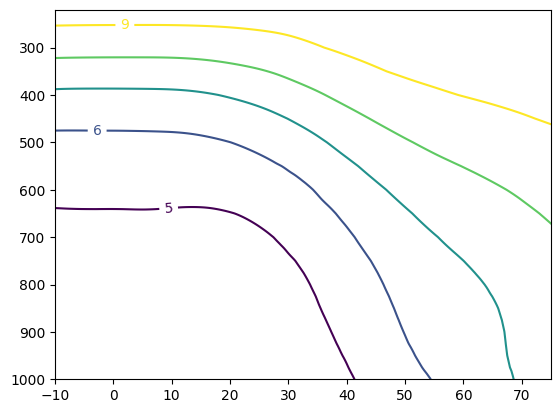

In [10]:
fig, ax = plt.subplots()
c = ax.contour(df.latitude,df.pressure_level,df.moist_lr.mean(['longitude','date']),levels=[5,6,7,8,9])
ax.invert_yaxis()
ax.set_xlim([-10,75])
ax.set_ylim([1000,220])
ax.clabel(c, c.levels, fontsize=10)

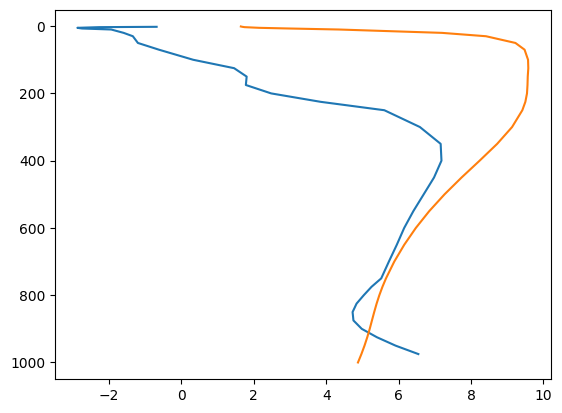

In [96]:
dlr = -9.8 # K/km
fig, ax = plt.subplots()
lat1 = 0
lat2 = 40
lat3 = 80
# ax.plot(df.lapse_rate.sel(latitude=lat1).mean(['longitude','date']) * 1000 * 9.81, df.z.sel(latitude=lat1).mean(['longitude','date'])/9.81/1000)
ax.plot(df.lapse_rate.sel(latitude=lat2).mean(['longitude','date']) * 1000 * 9.81, df.pressure_level)
# ax.plot(df.lapse_rate.sel(latitude=lat3).mean(['longitude','date']) * 1000 * 9.81, df.z.sel(latitude=lat3).mean(['longitude','date'])/9.81/1000)

# ax.plot(np.full(len(df.pressure_level), dlr),df.pressure_level/9.81/1000)
ax.plot(df.moist_lr.sel(latitude=lat2).mean(['longitude','date']),
    df.pressure_level
)

ax.invert_yaxis()
# ax.set_xscale('log')

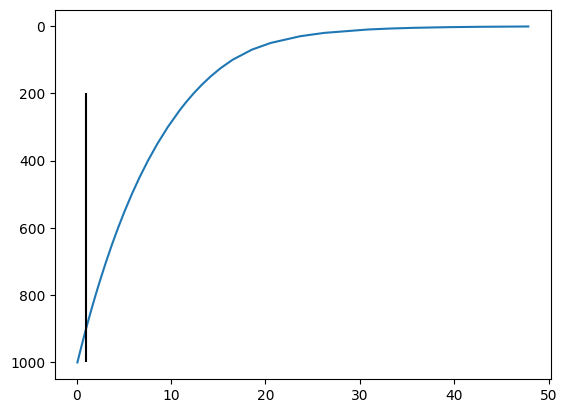

In [98]:
dlr = -9.8 # K/km
fig, ax = plt.subplots()
lat1 = 0
lat2 = 40
lat3 = 80
ax.plot(df.z.sel(latitude=0).mean(['longitude','date']) / 1000 / 9.81, df.pressure_level)
ax.vlines(x=1,ymin=200,ymax=1000,color='black')

ax.invert_yaxis()
ax.set_xl
# ax.set_xscale('log')

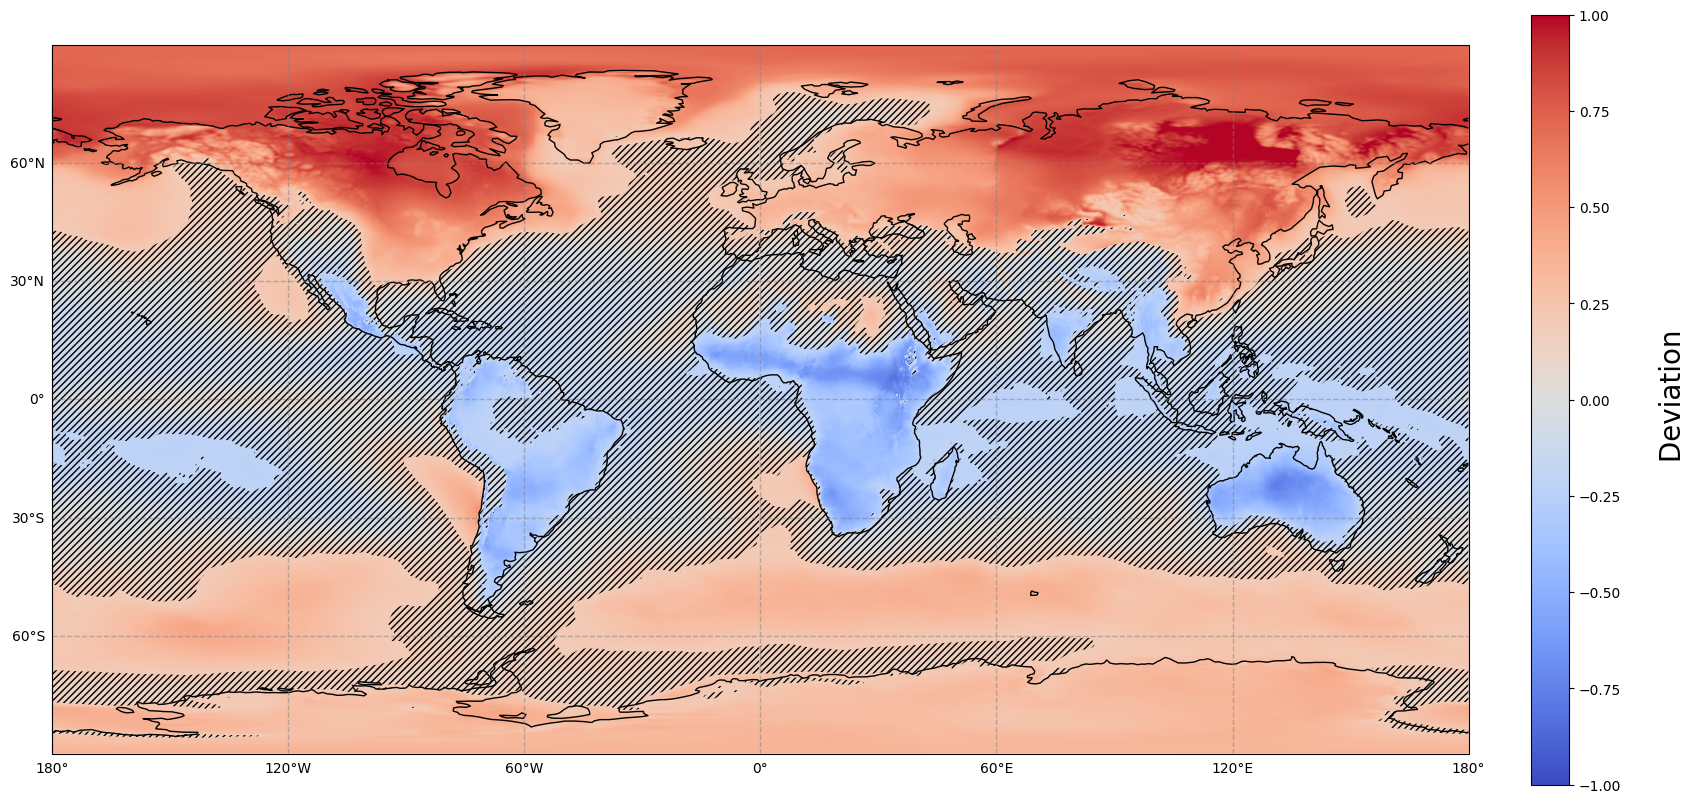

In [124]:
fig, ax = plt.subplots(1, figsize=(20,10), subplot_kw = {'projection':ccrs.PlateCarree()})

cmap = cm.coolwarm
im1 = ax.pcolormesh(df.longitude, df.latitude,
                   df.deviation.isel(date=0).where(df.pressure_level >= 500).mean('pressure_level'), 
                    transform=ccrs.PlateCarree(),cmap = cmap,vmax=1,vmin=-1)

im2 = ax.contourf(df.longitude, df.latitude,
                   df.deviation.isel(date=0).where(df.pressure_level >= 500).mean('pressure_level'), 
                    transform=ccrs.PlateCarree(),levels = [-0.2,0.2], hatches = [5*'/',''],colors='none')

ax.coastlines(color='black')

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

cbar = plt.colorbar(im1,ax=ax,fraction=0.046, pad=0.04)
cbar.set_label('\n Deviation',fontsize=20)


In [10]:
df_full = xr.open_dataset('df_Jan_22_25.nc')

In [11]:
df2 = df_full[['Q','sshf','slhf','tp_watts']].where(df_full.Q.year == 2000, drop=True)

In [12]:
df2 = df2.expand_dims(dim={'pressure_level': [1000]})

In [13]:
df3 = xr.merge((df, df2))

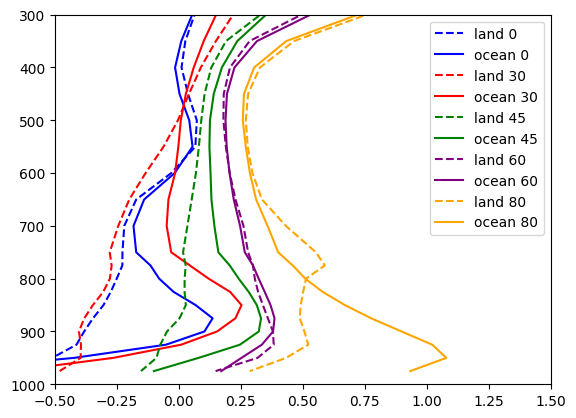

In [43]:
fig, ax = plt.subplots()
ax.plot(df3.deviation.where(df3.lapse_rate.land==1).sel(latitude=0).mean(['date','longitude']), 
        df3.pressure_level, label='land 0', color='blue',linestyle='--')
ax.plot(df3.deviation.where(df3.lapse_rate.land==0).sel(latitude=0).mean(['date','longitude']), 
        df3.pressure_level, label='ocean 0', color='blue',linestyle='-')
ax.plot(df3.deviation.where(df3.lapse_rate.land==1).sel(latitude=30).mean(['date','longitude']), 
        df3.pressure_level, label='land 30', color='red',linestyle='--')
ax.plot(df3.deviation.where(df3.lapse_rate.land==0).sel(latitude=30).mean(['date','longitude']), 
        df3.pressure_level, label='ocean 30', color='red',linestyle='-')
ax.plot(df3.deviation.where(df3.lapse_rate.land==1).sel(latitude=45).mean(['date','longitude']), 
        df3.pressure_level, label='land 45', color='green',linestyle='--')
ax.plot(df3.deviation.where(df3.lapse_rate.land==0).sel(latitude=45).mean(['date','longitude']), 
        df3.pressure_level, label='ocean 45', color='green',linestyle='-')
ax.plot(df3.deviation.where(df3.lapse_rate.land==1).sel(latitude=60).mean(['date','longitude']), 
        df3.pressure_level, label='land 60', color='purple',linestyle='--')
ax.plot(df3.deviation.where(df3.lapse_rate.land==0).sel(latitude=60).mean(['date','longitude']), 
        df3.pressure_level, label='ocean 60', color='purple',linestyle='-')
ax.plot(df3.deviation.where(df3.lapse_rate.land==1).sel(latitude=80).mean(['date','longitude']), 
        df3.pressure_level, label='land 80', color='orange',linestyle='--')
ax.plot(df3.deviation.where(df3.lapse_rate.land==0).sel(latitude=80).mean(['date','longitude']), 
        df3.pressure_level, label='ocean 80', color='orange',linestyle='-')

ax.invert_yaxis()
ax.set_ylim([1000,300])
ax.legend()
ax.set_xlim([-0.5,1.5])
plt.show()


In [48]:
df3['R1'] = 1 + (df3.slhf + df3.sshf)/df3.Q

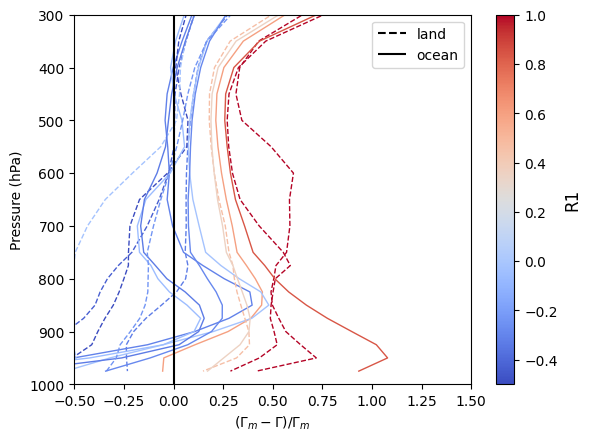

In [98]:
fig, ax = plt.subplots()

month = 0

cmap = plt.get_cmap('coolwarm')

# Create a normalization object

sm = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=plt.Normalize(vmin=-0.5, vmax=1))

norm = plt.Normalize(-0.5, 1)

# Plot the lines, coloring them based on the 'z' variable

lats = np.arange(-80,90,20)

for i in lats:
    # im = ax.plot(df3.deviation.where(df3.lapse_rate.land==1).sel(latitude=i).isel(date=month).mean(['longitude']), 
    #             df3.pressure_level, linestyle='--',linewidth=1,
    #             c=cmap(norm(df3.R1.where(df3.R1.land==1).sel(latitude=i).isel(date=month).mean(['longitude','pressure_level'])))
    #             )
    # ax.plot(df3.deviation.where(df3.lapse_rate.land==0).sel(latitude=i).isel(date=month).mean(['longitude']), 
    #         df3.pressure_level, linestyle='-',linewidth=1,
    #         c=cmap(norm(df3.R1.where(df3.R1.land==0).sel(latitude=i).isel(date=month).mean(['longitude','pressure_level'])))
    #        )
    im = ax.plot(df3.deviation.where(df3.lapse_rate.land==1).sel(latitude=i).mean(['longitude','date']), 
                df3.pressure_level, linestyle='--',linewidth=1,
                c=cmap(norm(df3.R1.where(df3.R1.land==1).sel(latitude=i).mean(['longitude','pressure_level','date'])))
                )
    ax.plot(df3.deviation.where(df3.lapse_rate.land==0).sel(latitude=i).mean(['longitude','date']), 
            df3.pressure_level, linestyle='-',linewidth=1,
            c=cmap(norm(df3.R1.where(df3.R1.land==0).sel(latitude=i).mean(['longitude','pressure_level','date'])))
           )

cbar = plt.colorbar(sm, ax = ax)
cbar.set_label('R1', fontsize=12)
ax.invert_yaxis()
ax.set_ylim([1000,300])
ax.set_xlim([-0.5,1.5])
ax.vlines(x=0,ymin=1000,ymax=300,color='k')
ax.hlines(y=0,xmin=0,xmax=0.1,linestyle='--',label='land',color='k')
ax.hlines(y=0,xmin=0,xmax=0.1,linestyle='-',label='ocean',color='k')
ax.legend()
ax.set_xlabel(r'$(\Gamma_m - \Gamma) / \Gamma_m$')
ax.set_ylabel('Pressure (hPa)')

plt.show()


In [92]:
df3['deviation_c'] = (6.5 - df3.lapse_rate * 9810) / 6.5

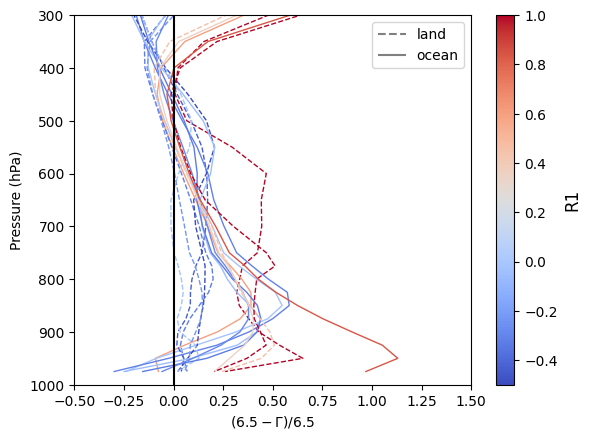

In [99]:
fig, ax = plt.subplots()

month = 0

cmap = plt.get_cmap('coolwarm')

# Create a normalization object

sm = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=plt.Normalize(vmin=-0.5, vmax=1))

norm = plt.Normalize(-0.5, 1)

# Plot the lines, coloring them based on the 'z' variable

lats = np.arange(-80,90,20)

for i in lats:
    # im = ax.plot(df3.deviation.where(df3.lapse_rate.land==1).sel(latitude=i).isel(date=month).mean(['longitude']), 
    #             df3.pressure_level, linestyle='--',linewidth=1,
    #             c=cmap(norm(df3.R1.where(df3.R1.land==1).sel(latitude=i).isel(date=month).mean(['longitude','pressure_level'])))
    #             )
    # ax.plot(df3.deviation.where(df3.lapse_rate.land==0).sel(latitude=i).isel(date=month).mean(['longitude']), 
    #         df3.pressure_level, linestyle='-',linewidth=1,
    #         c=cmap(norm(df3.R1.where(df3.R1.land==0).sel(latitude=i).isel(date=month).mean(['longitude','pressure_level'])))
    #        )
    im = ax.plot(df3.deviation_c.where(df3.lapse_rate.land==1).sel(latitude=i).mean(['longitude','date']), 
                df3.pressure_level, linestyle='--',linewidth=1,
                c=cmap(norm(df3.R1.where(df3.R1.land==1).sel(latitude=i).mean(['longitude','pressure_level','date'])))
                )
    ax.plot(df3.deviation_c.where(df3.lapse_rate.land==0).sel(latitude=i).mean(['longitude','date']), 
            df3.pressure_level, linestyle='-',linewidth=1,
            c=cmap(norm(df3.R1.where(df3.R1.land==0).sel(latitude=i).mean(['longitude','pressure_level','date'])))
           )

cbar = plt.colorbar(sm, ax = ax)
cbar.set_label('R1', fontsize=12)
ax.invert_yaxis()
ax.set_ylim([1000,300])
ax.set_xlim([-0.5,1.5])
ax.vlines(x=0,ymin=1000,ymax=300,color='k')
ax.hlines(y=0,xmin=0,xmax=0.1,linestyle='--',label='land',color='gray')
ax.hlines(y=0,xmin=0,xmax=0.1,linestyle='-',label='ocean',color='gray')
ax.legend()
ax.legend()
ax.set_xlabel(r'$(6.5 - \Gamma) / 6.5$')
ax.set_ylabel('Pressure (hPa)')

plt.show()


In [83]:
df3.deviation.where(df3.lapse_rate.land==1).sel(latitude=-80)

<xarray.DataArray 'deviation' (date: 12, pressure_level: 37, longitude: 1440)> Size: 5MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [1.71512052, 1.71510965, 1.71510965, ..., 1.71518587,
         1.71518292, 1.71512323],
        [2.29855087, 2.29855087, 2.2984756 , ..., 2.29864434,
         2.29864434, 2.29855087],
        ...,
        [0.16111943, 0.16133616, 0.16089092, ..., 0.16099174,
         0.1615568 , 0.1614086 ],
        [0.14904719, 0.15001843, 0.15151374, ..., 0.14624978,
         0.14622071, 0.14738595],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [1.98433443, 1.98446592, 1.9846006 , ..., 1.98398806,
         1.9841342 , 1.98420002],
        [2.25780368, 2.25782695, 2.25779074, ..., 2.25785416,
         2.25777713, 2.25782164],
...
        [0.20628193, 0.20585113, 0.20531521, ..., 0.20821587,
         0.20807204, 0.20662852],
        [0.19266179, 0.19378666, 0.19576269, ..., 0.19373611,
         0.19296495, 0.19269649],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [1.70873448, 1.70885264, 1.70885264, ..., 1.70855164,
         1.70866747, 1.70866747],
        [2.51021021, 2.51029574, 2.51047226, ..., 2.50996436,
         2.50995343, 2.51003384],
        ...,
        [0.15109868, 0.15088735, 0.15123662, ..., 0.15127784,
         0.15193762, 0.15189487],
        [0.13656866, 0.13700553, 0.13804458, ..., 0.13487939,
         0.1348396 , 0.13540215],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * date            (date) int64 96B 20000101 20000201 ... 20001101 20001201
  * pressure_level  (pressure_level) float64 296B 1.0 2.0 3.0 ... 975.0 1e+03
    latitude        float64 8B -80.0
  * longitude       (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    number          int64 8B 0
    expver          (date) <U4 192B '0001' '0001' '0001' ... '0001' '0001'
    month           (date) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    year            (date) int64 96B 2000 2000 2000 2000 ... 2000 2000 2000 2000
    land            (date, longitude) bool 17kB True True True ... True True

In [72]:
df3.R1.where(df3.R1.land==0).sel(latitude=45).isel(date=month).mean(['longitude','pressure_level'])

<xarray.DataArray 'R1' ()> Size: 4B
array(0.52254707, dtype=float32)
Coordinates:
    date      int64 8B 20000801
    latitude  float64 8B 45.0
    number    int64 8B 0
    expver    <U4 16B '0001'
    month     int64 8B 8
    year      int64 8B 2000

In [70]:
df3.date

<xarray.DataArray 'date' (date: 12)> Size: 96B
array([20000101, 20000201, 20000301, 20000401, 20000501, 20000601, 20000701,
       20000801, 20000901, 20001001, 20001101, 20001201])
Coordinates:
  * date     (date) int64 96B 20000101 20000201 20000301 ... 20001101 20001201
    number   int64 8B 0
    expver   (date) <U4 192B '0001' '0001' '0001' ... '0001' '0001' '0001'
    month    (date) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    year     (date) int64 96B 2000 2000 2000 2000 2000 ... 2000 2000 2000 2000

In [41]:
df3.to_netcdf('df_lapse.nc')

In [ ]:
fig, ax = plt.subplots()
ax.plot(df3.deviation.where(df3.lapse_rate.land==1).sel(latitude=0).mean(['date','longitude']), 
        df3.pressure_level, label='lr land')
ax.plot(df3.deviation.where(df3.lapse_rate.land==0).sel(latitude=0).mean(['date','longitude']), 
        df3.pressure_level, label='lr ocean')
# ax.plot(df3.moist_lr.where(df3.lapse_rate.land==1).sel(latitude=0).mean(['date','longitude']), 
#         df3.pressure_level, label='moist land')
# ax.plot(df3.moist_lr.where(df3.lapse_rate.land==0).sel(latitude=0).mean(['date','longitude']), 
#         df3.pressure_level, label='moist ocean')

ax.invert_yaxis()
ax.set_ylim([1000,300])
ax.legend()
plt.show()
